In [1]:
# import all packages required for this analysis
import pandas as pd
import numpy as np
import plotly.express as px
import os
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import random

In [2]:
# load raw data into working space
raw_users = pd.read_csv('~/Downloads/revolut/data/rev-users.csv')
raw_transactions = pd.read_csv('~/Downloads/revolut/data/rev-transactions.csv')
raw_notifications = pd.read_csv('~/Downloads/revolut/data/rev-notifications.csv')
raw_devices = pd.read_csv('~/Downloads/revolut/data/rev-devices.csv')


users = raw_users
transactions = raw_transactions
notifications = raw_notifications
devices = raw_devices

### Let's defined engaged user. One way is to define it through the recency of an activity of a user.

### For example: If a user has done atleast 1 transactions in last X days label it as engaged else churned. To find X we'll look at the distribution of recency distribution of an user. Recency defined as: (analysis date - Last user transaction date)

In [3]:
transactions['created_date'] = pd.to_datetime(transactions['created_date'])
transactions['transaction_date'] = [td.date() for td in transactions['created_date']]

In [4]:
# find the latest transaction date in the data. This will be use to calculate recency
max(transactions['transaction_date'])

datetime.date(2019, 5, 16)

In [5]:
# since each user has only transaction this step is not neccesary for this analysis. 
# But I am keeping it to generalise it
max_trans_date = transactions.groupby(['user_id']).agg({'transaction_date': np.max})
max_trans_date = max_trans_date.reset_index()

In [6]:
# calculate the recency of transaction for each user
max_trans_date['recency'] = datetime.datetime.strptime('2019-05-16', '%Y-%m-%d').date() - max_trans_date['transaction_date']
max_trans_date = max_trans_date.reset_index()
max_trans_date['recency'] = max_trans_date['recency'].dt.days

### how does recency distibution looks like?

### This will help us in identify the cut-off for the date range


In [7]:
recency_distribution = max_trans_date.groupby(['recency']).agg({'user_id' : 'count'})
recency_distribution = recency_distribution.reset_index()

Text(0.5, 1.0, 'Recency distribution of users transaction on Revolut')

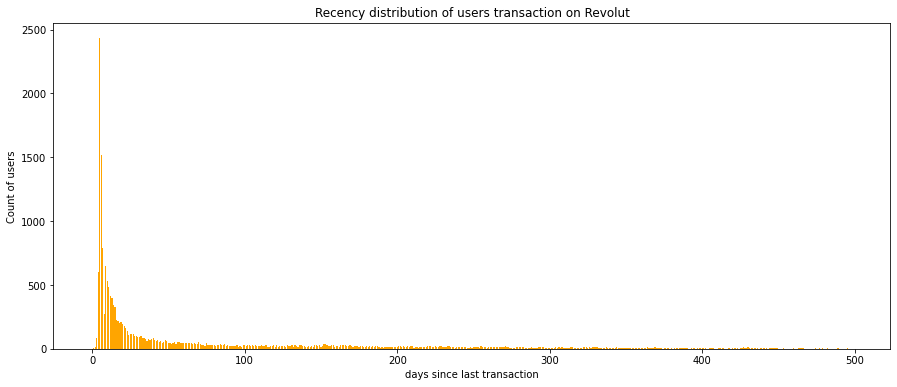

In [8]:
plt.figure(figsize=(15,6))
plt.bar(recency_distribution['recency'], recency_distribution['user_id'], color = 'orange')
plt.xlabel('days since last transaction')
plt.ylabel('Count of users')
plt.title('Recency distribution of users transaction on Revolut')

### As we can see from above graph there is a long tail. This means lot of users have not done any transactions for over 90 days now. We can safely assume that they are no longer engaged 

#### Let's make the above graph little more readable by binning all users who have not done any transations in last 90 days 

In [9]:
# club all users who have not done any transaction in last 90 days into a '91' group
max_trans_date['recency'] = np.where(max_trans_date['recency'] <= 90, max_trans_date['recency'], 91)

recency_distribution = max_trans_date.groupby(['recency']).agg({'user_id' : 'count'})
recency_distribution = recency_distribution.reset_index()

Text(0.5, 1.0, 'Recency distribution of users transaction on Revolut. 91 is all users who have not done any transaction in last 90 days')

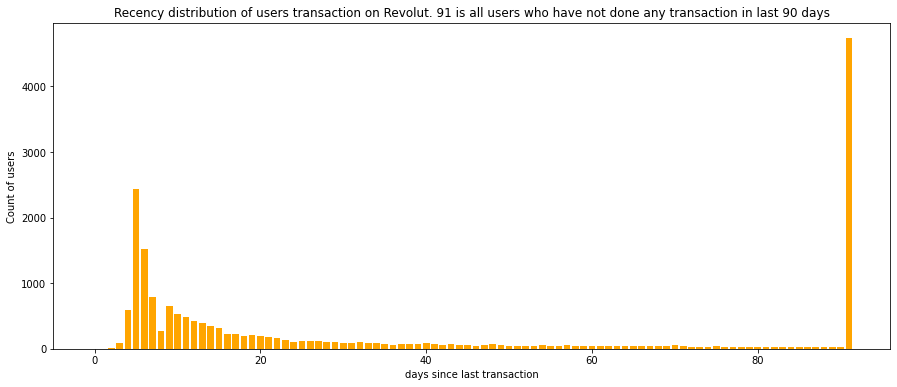

In [10]:
plt.figure(figsize=(15,6))
plt.bar(recency_distribution['recency'], recency_distribution['user_id'], color = 'orange')
plt.xlabel('days since last transaction')
plt.ylabel('Count of users')
plt.title('Recency distribution of users transaction on Revolut. 91 is all users who have not done any transaction in last 90 days')

# So We'll define Engaged user as: A User who has done at least one transaction in last 90 days 

## Let's do some cleaning of data for training our ML model 

In [11]:
merged_df = transactions.merge(users, how= 'left', on = 'user_id')
merged_df = merged_df.merge(notifications, how = 'left', on = 'user_id')
merged_df = merged_df.merge(devices, how = 'left', on = 'user_id')

In [12]:
merged_df.rename(columns={'created_date_y': 'user_created_date', 
                          'created_date' : 'notification_date'}, inplace = True)

# create a churn label ; label = 1 if no transaction in last 90 days (user churned) else 0

In [13]:
# create a label of engaged users.
# Definition: Users having atleast 1 transaction in last 90 days label them as engaged(1) else non-engaged(0)

# transaction data is already at user level 
merged_df['label'] = np.where((datetime.datetime.strptime('2019-05-16', '%Y-%m-%d').date() 
                              - merged_df['transaction_date']).dt.days <=90, 0, 1)

# Let's do some feature engineering which will help in the better learning of the model 

In [14]:
# create a new copy
clean_df = merged_df

# create date time features of notification date
clean_df['notification_date'] = pd.to_datetime(clean_df['notification_date'])
clean_df['notf_day'] = clean_df['notification_date'].dt.day
clean_df['notf_month'] = clean_df['notification_date'].dt.month
clean_df['notf_day_of_week'] = clean_df['notification_date'].dt.day_name()

In [15]:
# check for null in each column. Remove columns which have most of the values as null
clean_df.isnull().sum()*100/len(clean_df)

transaction_id                               0.000000
transactions_type                            0.000000
transactions_currency                        0.000000
amount_usd                                   0.000000
transactions_state                           0.000000
ea_cardholderpresence                       43.153293
ea_merchant_mcc                             42.729343
ea_merchant_city                            42.734534
ea_merchant_country                         42.743060
direction                                    0.000000
user_id                                      0.000000
created_date_x                               0.000000
transaction_date                             0.000000
birth_year                                   0.000000
country                                      0.000000
city                                         0.000000
user_created_date                            0.000000
user_settings_crypto_unlocked                0.000000
plan                        

In [16]:
# drop columns not useful for training a model. Also drop columns having lot of nulls 
drop_col = ['transaction_id', 'transactions_currency', 'ea_cardholderpresence', 'ea_merchant_mcc', 
           'ea_merchant_country', 'ea_merchant_city', 'user_id', 'created_date_x', 'transaction_date',
           'city', 'user_created_date', 'reason', 'notification_date', 'status', 'country']

clean_df = clean_df.drop(drop_col, axis = 1)

# Since we have enough data, I'll drop all na and null for this analysis
clean_df.dropna(how = 'any', inplace = True)

In [17]:
# ensure that we now don't have any nulls in the data 
clean_df.isnull().sum()*100/len(clean_df)

transactions_type                           0.0
amount_usd                                  0.0
transactions_state                          0.0
direction                                   0.0
birth_year                                  0.0
user_settings_crypto_unlocked               0.0
plan                                        0.0
attributes_notifications_marketing_push     0.0
attributes_notifications_marketing_email    0.0
num_contacts                                0.0
num_referrals                               0.0
num_successful_referrals                    0.0
channel                                     0.0
brand                                       0.0
label                                       0.0
notf_day                                    0.0
notf_month                                  0.0
notf_day_of_week                            0.0
dtype: float64

In [18]:
# Normalise all numeric features. This will help in faster and efficient learning of the model 
from sklearn.preprocessing import StandardScaler
num_col = clean_df.columns[clean_df.dtypes.apply(lambda x: np.issubdtype(x, np.number))]
num_col = num_col.drop('label')

sc = StandardScaler()
clean_df[num_col] = sc.fit_transform(clean_df[num_col])

In [19]:
# convert all non-numeric columns into one-hot encoded columms. 
# This is required as currently sklearn cannot handle categorical variable. 
str_col = clean_df.columns[clean_df.dtypes.apply(lambda x: np.issubdtype(x, np.number) == False)]
str_col = list(str_col)
clean_df = pd.get_dummies(clean_df, columns=str_col)

# Prepare training and testing dataset

In [20]:
# split data for training and testing
from sklearn.model_selection import train_test_split
y = clean_df.loc[:, ['label']].values
X = clean_df.drop(['label'], axis = 1).values

# split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [21]:
col_names = clean_df.drop(['label'], axis = 1).keys()

# Let's build our ML model. 

#### Since we have mix of categorical and numerical features, a tree based model might work best here. I'll start with a simple Random forest to first to get an understanding of features which are good predictors. I'll then try some advanced ensemble models like XGBoost. Finally since we have a large amount a data, I'll try neural nets which usually works well as data size increases

# RandomForest Classifier

In [22]:
# Since Random forest is taking a lot of time to train with full data, I'll train my model on the subset of the data  

In [23]:
ran = random.sample(range(0, len(X_train)), 50000)

In [24]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=20, random_state=0)
classifier.fit(X_train[ran], y_train[ran])

#make prediction on test data
y_pred = classifier.predict(X_test)
predictions = [round(values) for values in y_pred]

#evaluation of model
cm = confusion_matrix(y_test, predictions)
print(cm)

accuracy = accuracy_score(y_test, predictions)
print('Accuracy of randomforest model is {}'.format(accuracy*100.0))

<ipython-input-24-0db4f3456fc0>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X_train[ran], y_train[ran])


[[ 489931  919506]
 [ 476017 2290326]]
Accuracy of randomforest model is 66.58054303627107


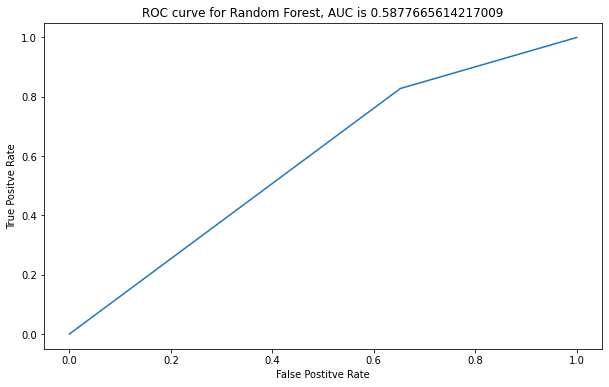

In [25]:
# Plot the ROC-AUC curve to check the performace of the model
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test, predictions)
auc = metrics.roc_auc_score(y_test, predictions)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr)
plt.xlabel('False Postitve Rate')
plt.ylabel('True Positve Rate')
plt.title('ROC curve for Random Forest, AUC is {}'.format(auc))
plt.show()

# Plot feature importance to understand what are the important feature to predict user engagement

Text(0.5, 1.0, 'Feature importance in predicting churn')

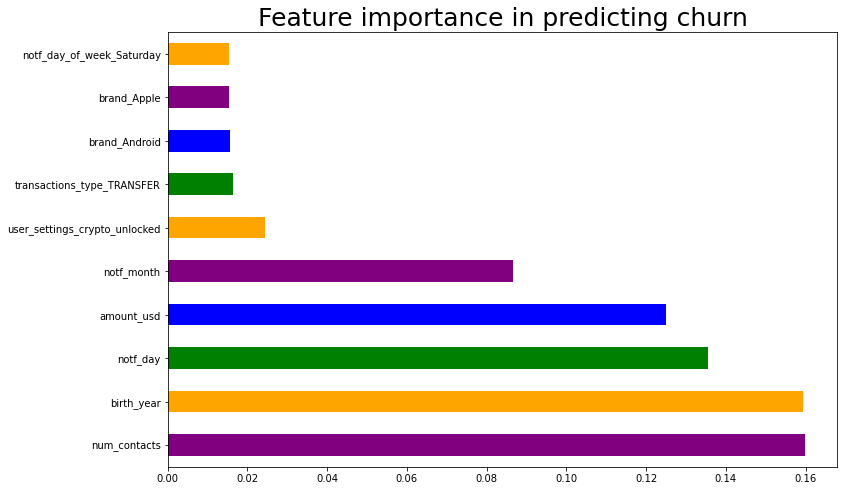

In [26]:
plt.figure(figsize=(12,8))
feat_importances = pd.Series(classifier.feature_importances_, index=col_names)
feat_importances.nlargest(10).plot(kind='barh', color = ['purple', 'orange', 'green', 'blue'])
plt.title('Feature importance in predicting churn', fontsize = 25)

# XGB Classifier 


/usr/local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[[ 303505 1105932]
 [ 168786 2597557]]
Accuracy of XGB Classifier is 69.47353548319116


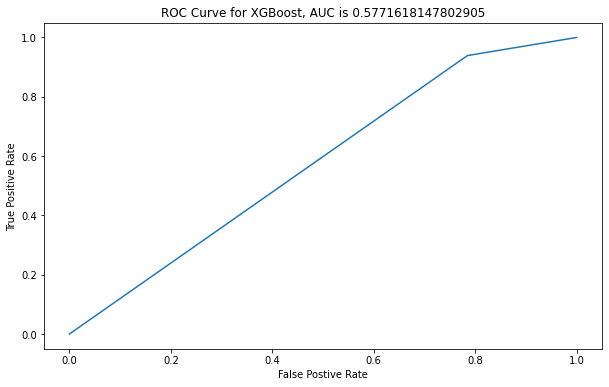

In [27]:
# fit an XGBoost model
import xgboost
from xgboost import XGBClassifier
classifier = XGBClassifier()

classifier.fit(X_train[ran], y_train[ran])

#make predictions
y_pred =classifier.predict(X_test)
predictions = [round(value) for value in y_pred]

#model evaluation
accuracy = accuracy_score(y_test, predictions)
cm = confusion_matrix(y_test, predictions)

print(cm)
print('Accuracy of XGB Classifier is {}'.format(accuracy*100.0))

#plot ROC-AUC curve
fpr, tpr, _ = metrics.roc_curve(y_test, predictions)
auc = metrics.roc_auc_score(y_test, predictions)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr)
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost, AUC is {}'.format(auc))
plt.show()

# Neural networks 

In [28]:
import tensorflow as tf
from tensorflow import keras 
from keras import Sequential
from keras.layers import Dense

classifier = Sequential()

#First hidden layer
classifier.add(Dense(10, activation = 'relu', kernel_initializer = 'random_normal', input_dim = len(X_train[0])))

# Second hidden layer
classifier.add(Dense(10, activation  = 'relu', kernel_initializer = 'random_normal'))

# output layer
classifier.add(Dense(1, activation ='sigmoid', kernel_initializer = 'random_normal'))


#compile the network
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
classifier.fit(X_train, y_train, batch_size = 2000, epochs = 10)

#evaluation
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

cm = confusion_matrix(y_test, y_pred)
print(cm)

accuracy = accuracy_score(y_test, y_pred)

print("Accuracy of Neural networks is {}".format(accuracy*100))

Epoch 1/10
4872/4872 [==============================] - 4s 848us/step - loss: 0.6135 - accuracy: 0.6833
Epoch 2/10
4872/4872 [==============================] - 4s 804us/step - loss: 0.6071 - accuracy: 0.6878
Epoch 3/10
4872/4872 [==============================] - 4s 809us/step - loss: 0.6060 - accuracy: 0.6881
Epoch 4/10
4872/4872 [==============================] - 4s 801us/step - loss: 0.6055 - accuracy: 0.6883
Epoch 5/10
4872/4872 [==============================] - 4s 810us/step - loss: 0.6051 - accuracy: 0.6883
Epoch 6/10
4872/4872 [==============================] - 4s 825us/step - loss: 0.6049 - accuracy: 0.6883
Epoch 7/10
4872/4872 [==============================] - 4s 823us/step - loss: 0.6048 - accuracy: 0.6884
Epoch 8/10
4872/4872 [==============================] - 4s 825us/step - loss: 0.6047 - accuracy: 0.6883
Epoch 9/10
4872/4872 [==============================] - 4s 822us/step - loss: 0.6046 - accuracy: 0.6884
Epoch 10/10
4872/4872 [==============================] - 4s 824u

# Solution of Q4 

### We can run a A/B experiment to check if the action we are taking is reducing churn or not. 

### Following are the key steps in designing such an experiment:

1. Randomise the group at user level into control and experiment
2. Continue the current actions for the control group. Implement new action based on the model for the experiment group
3. Define a metric of interest to measure success. For churn, success metric could be: % of users who have done at least 1 transactions / total users in the group for the experiment duration 
4. Compare performace on the metric defined in step3 between control and experiment group
5. Do a statistical test to check if the results are significant (and not just due to random chance)

